In [1]:
import cv2
from glob import glob
import numpy as np
from PIL import Image, ImageOps

import tensorflow as tf
import PIL.ImageOps

from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras import Sequential, Input, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Add
from tensorflow.keras.layers import Activation, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
# Create a dictionary to store each form ID and its writer
import os
from itertools import islice

form_writer = {}
forms_file_path = "IAM Dataset/forms.txt"
with open(forms_file_path) as f:
    for line in islice(f, 16, None):
        line_list = line.split(' ')
        form_id = line_list[0]
        writer = line_list[1]
        form_writer[form_id] = writer
form_writer

{'a01-020x': '010',
 'a01-026': '009',
 'a01-026u': '000',
 'a01-026x': '008',
 'a01-030': '005',
 'a01-030u': '000',
 'a01-030x': '010',
 'a01-038': '007',
 'a01-038x': '011',
 'a01-043': '012',
 'a01-043u': '000',
 'a01-043x': '011',
 'a01-049': '012',
 'a01-049u': '000',
 'a01-049x': '000',
 'a01-053': '013',
 'a01-053u': '000',
 'a01-053x': '014',
 'a01-058': '013',
 'a01-058u': '000',
 'a01-058x': '014',
 'a01-063': '013',
 'a01-063u': '000',
 'a01-063x': '015',
 'a01-068u': '000',
 'a01-072u': '000',
 'a01-072x': '001',
 'a01-077': '016',
 'a01-077u': '000',
 'a01-082u': '000',
 'a01-087': '017',
 'a01-087u': '000',
 'a01-091': '016',
 'a01-091u': '000',
 'a01-096u': '000',
 'a01-102': '016',
 'a01-102u': '000',
 'a01-107': '018',
 'a01-107u': '000',
 'a01-113': '018',
 'a01-113u': '000',
 'a01-117': '019',
 'a01-117u': '000',
 'a01-122': '019',
 'a01-122u': '000',
 'a01-128': '019',
 'a01-128u': '000',
 'a01-132': '020',
 'a01-132u': '000',
 'a01-132x': '000',
 'a02-000': '021',

## Select the 50 most productive writers

In [3]:
from collections import Counter

top_writers = []
num_writers = 50
writers_counter = Counter(form_writer.values())
for writer_id,_ in writers_counter.most_common(num_writers):
    top_writers.append(writer_id)

In [4]:
top_forms = []
for form_id, author_id in form_writer.items():
    if author_id in top_writers:
        top_forms.append(form_id)
len(top_forms)

446

## Create temp directory to save writers' forms in

In [5]:
import os
import glob
import shutil
temp_sentences_path = "IAM Dataset/temp_sentences"
if not os.path.exists(temp_sentences_path):
    os.makedirs(temp_sentences_path)
    # Copy forms that belong to the top 50 most common writers to the temp directory
    original_sentences_path = "IAM Dataset/sentences/**/**/*.png"
    for file_path in glob.glob(original_sentences_path):
        image_name = file_path.split('\\')[-1]
        file_name, _ = os.path.splitext(image_name)
        form_id = '-'.join(file_name.split('-')[0:2])
        if form_id in top_forms:
            shutil.copy2(file_path, temp_sentences_path + "/" + image_name)

In [6]:
import numpy as np

img_files = np.zeros((0), dtype=np.str)
img_targets = np.zeros((0), dtype=np.str)
path_to_files = os.path.join(temp_sentences_path, '*')
for file_path in glob.glob(path_to_files):
    img_files = np.append(img_files, file_path)
    file_name, _ = os.path.splitext(file_path.split('\\')[-1]  )
    form_id = '-'.join(file_name.split('-')[0:2])
    for key in form_writer:
        if key == form_id:
            img_targets = np.append(img_targets, form_writer[form_id])

C:\Users\Diego\AppData\Local\Temp\ipykernel_17572\1316896891.py:3: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  img_files = np.zeros((0), dtype=np.str)
C:\Users\Diego\AppData\Local\Temp\ipykernel_17572\1316896891.py:4: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  img_targets = np.zeros((0), dtype=np.str)


In [7]:
print(img_files[:5])
print(img_targets[:5])

['IAM Dataset/temp_sentences\\a01-026u-00.png'
 'IAM Dataset/temp_sentences\\a01-026u-01.png'
 'IAM Dataset/temp_sentences\\a01-026u-02.png'
 'IAM Dataset/temp_sentences\\a01-026u-03.png'
 'IAM Dataset/temp_sentences\\a01-026u-04.png']
['000' '000' '000' '000' '000']


True

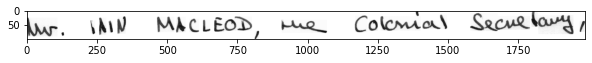

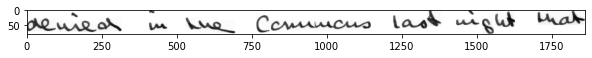

In [13]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

for file_name in img_files[:2]:
    img = mpimg.imread(file_name)
    plt.figure(figsize = (10,10))
    plt.imshow(img, cmap ='gray')
img = cv2.imread(img_files[3])


In [14]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(img_targets)
encoded_img_targets = encoder.transform(img_targets)

print("Writer ID        : ", img_targets[:2])
print("Encoded writer ID: ", encoded_img_targets[:2])

Writer ID        :  ['000' '000']
Encoded writer ID:  [0 0]


## Split Train Test Validation

In [15]:
from sklearn.model_selection import train_test_split

# Split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(img_files, encoded_img_targets, test_size=0.2, shuffle = True)

# Further split training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle = True)

print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(2492,) (624,) (779,)
(2492,) (624,) (779,)


In [16]:
CROP_SIZE = 113
NUM_LABELS = 50
BATCH_SIZE = 16

## Augmentation

In [17]:
from sklearn.utils import shuffle
from PIL import Image
import random

def get_augmented_sample(sample, label, sample_ratio):
    # Get current image details
    img = Image.open(sample)
    img_width = img.size[0]
    img_height = img.size[1]

    # Compute resize dimensions such that aspect ratio is maintained
    height_fac = CROP_SIZE / img_height
    size = (int(img_width * height_fac), CROP_SIZE)

    # Resize image
    new_img = img.resize((size), Image.ANTIALIAS)
    new_img_width = new_img.size[0]
    new_img_height = new_img.size[1]

    # Generate a random number of crops of size 113x113 from the resized image
    x_coord = list(range(0, new_img_width - CROP_SIZE))
    num_crops = int(len(x_coord) * sample_ratio)
    random_x_coord = random.sample(x_coord, num_crops)

    # Create augmented images (cropped forms) and map them to a label (writer)
    images = []
    labels = []
    for x in random_x_coord:
        img_crop = new_img.crop((x, 0, x + CROP_SIZE, CROP_SIZE))
        # Transform image to an array of numbers
        images.append(np.asarray(img_crop))
        labels.append(label)

    return (images, labels)

Label:  22


True

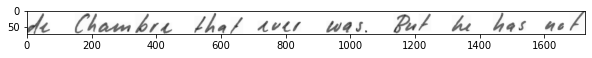

In [36]:
sample, label = X_train[0], y_train[0]
img = cv2.imread(sample)
plt.figure(figsize = (10,10))
plt.imshow(img, cmap ='gray')
print("Label: ", label)

In [32]:
images, labels = get_augmented_sample(sample, label, 0.1)

C:\Users\Diego\AppData\Local\Temp\ipykernel_17572\4186496213.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  new_img = img.resize((size), Image.ANTIALIAS)


In [33]:
print(labels)
print("Num of labels: ", len(labels))

[22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22,

263


True

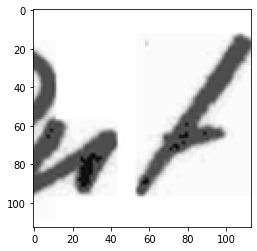

In [34]:
print(len(images))
plt.imshow(images[0], cmap ='gray')

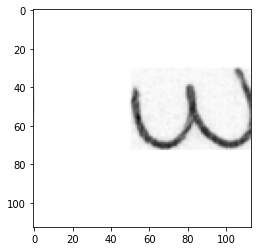

In [17]:
plt.imshow(images[1], cmap ='gray')

In [18]:
import operator
from functools import reduce
from keras.utils import to_categorical

def generate_data(samples, labels, batch_size, sample_ratio):
    while 1:
        for offset in range(0, len(samples), batch_size):
            batch_samples = samples[offset:(offset + batch_size)]
            batch_labels = labels[offset:(offset + batch_size)]

            # Augment each sample in batch
            augmented_batch_samples = []
            augmented_batch_labels = []
            for i in range(len(batch_samples)):
                sample = batch_samples[i]
                label = batch_labels[i]
                augmented_samples, augmented_labels = get_augmented_sample(sample, label, sample_ratio)
                augmented_batch_samples.append(augmented_samples)
                augmented_batch_labels.append(augmented_labels)

            # Flatten out samples and labels
            augmented_batch_samples = reduce(operator.add, augmented_batch_samples)
            augmented_batch_labels = reduce(operator.add, augmented_batch_labels)

            # Reshape input format
            X_train = np.array(augmented_batch_samples)
            X_train = X_train.reshape(X_train.shape[0], CROP_SIZE, CROP_SIZE, 1)

            # Transform input to float and normalize
            X_train = X_train.astype('float32')
            X_train /= 255

            # Encode y
            y_train = np.array(augmented_batch_labels)
            y_train = to_categorical(y_train, NUM_LABELS)

            yield X_train, y_train

In [19]:
train_generator = generate_data(X_train, y_train, BATCH_SIZE, 0.3)
validation_generator = generate_data(X_val, y_val, BATCH_SIZE, 0.3)
test_generator = generate_data(X_test, y_test, BATCH_SIZE, 0.1)

In [23]:
def resize_image(img):
    size = round(CROP_SIZE/2)
    return tf.image.resize(img, [size, size])

## CNN

In [24]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda, Activation
from keras.layers.convolutional import Convolution2D, ZeroPadding2D, MaxPooling2D
from keras.optimizers import Adam
from keras import metrics

model = Sequential()

# Define network input shape
model.add(ZeroPadding2D((1, 1), input_shape=(CROP_SIZE, CROP_SIZE, 1)))
# Resize images to allow for easy computation
model.add(Lambda(resize_image))

# CNN model - Building the model suggested in paper
model.add(Convolution2D(filters= 32, kernel_size =(5,5), strides= (2, 2), padding='same', name='conv1'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='pool1'))

model.add(Convolution2D(filters= 64, kernel_size =(3, 3), strides= (1, 1), padding='same', name='conv2'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='pool2'))

model.add(Convolution2D(filters= 128, kernel_size =(3, 3), strides= (1, 1), padding='same', name='conv3'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='pool3'))


model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(512, name='dense1'))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(256, name='dense2'))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(NUM_LABELS, name='output'))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['acc'])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d_1 (ZeroPaddi  (None, 115, 115, 1)      0         
 ng2D)                                                           
                                                                 
 lambda_1 (Lambda)           (None, 56, 56, 1)         0         
                                                                 
 conv1 (Conv2D)              (None, 28, 28, 32)        832       
                                                                 
 activation (Activation)     (None, 28, 28, 32)        0         
                                                                 
 pool1 (MaxPooling2D)        (None, 14, 14, 32)        0         
                                                                 
 conv2 (Conv2D)              (None, 14, 14, 64)        18496     
                                                      

## Training and Saving checkpoint

In [32]:
from keras.callbacks import ModelCheckpoint

# Create directory to save checkpoints at
model_checkpoints_path = "./model_checkpoints"
if not os.path.exists(model_checkpoints_path):
    os.makedirs(model_checkpoints_path)

# Save model after every epoch using checkpoints
create_checkpoint = ModelCheckpoint(
    filepath = "./model_checkpoints/check_{epoch:02d}_{val_loss:.4f}.hdf5",
    verbose = 1,
    save_best_only = False
)

# Fit model using generators
history_object = model.fit_generator(
    train_generator,
    steps_per_epoch = round(len(X_train) / BATCH_SIZE),
    validation_data = validation_generator,
    validation_steps = round(len(X_val) / BATCH_SIZE),
    epochs = 200,
    verbose = 1,
    callbacks = [create_checkpoint]
)

C:\Users\Diego\AppData\Local\Temp\ipykernel_8532\3810275414.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_object = model.fit_generator(
C:\Users\Diego\AppData\Local\Temp\ipykernel_8532\4186496213.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  new_img = img.resize((size), Image.ANTIALIAS)


Epoch 1/20
  9/156 [>.............................] - ETA: 13:33 - loss: 1.0214 - acc: 0.6820

KeyboardInterrupt: 

In [29]:
model_weights_path = "model_checkpoints\check_20_0.7512.hdf5"
if model_weights_path:
    model.load_weights(model_weights_path)
    scores = model.evaluate_generator(test_generator, steps=round(len(X_test)/BATCH_SIZE))
    print("Accuracy: ", scores[1])
else:
    print("Set model weights file to load in the 'model_weights_path' variable")

C:\Users\Diego\AppData\Local\Temp\ipykernel_8532\4033021946.py:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scores = model.evaluate_generator(test_generator, steps=round(len(X_test)/BATCH_SIZE))
C:\Users\Diego\AppData\Local\Temp\ipykernel_8532\4186496213.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  new_img = img.resize((size), Image.ANTIALIAS)


Accuracy:  0.7758903503417969
